# Logistic Growth Models

Logistic growth models have both exponential growth and decline within the same model.





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dashboard.mplstyle')

In [9]:
def logistic_func(x, L, x0, k):
    """
    Logistic function for modeling data.

    Parameters
    ----------
    x : array
    L, x0, k : float

    Returns
    -------
    array
    """
    return L / (1 + np.exp(-k * (x - x0)))


In [10]:
from functions import logistic_func
logistic_func(np.arange(20), 5000, 12, 0.1).round(-1)

array([1160., 1250., 1340., 1450., 1550., 1660., 1770., 1890., 2010.,
       2130., 2250., 2380., 2500., 2620., 2750., 2870., 2990., 3110.,
       3230., 3340.])

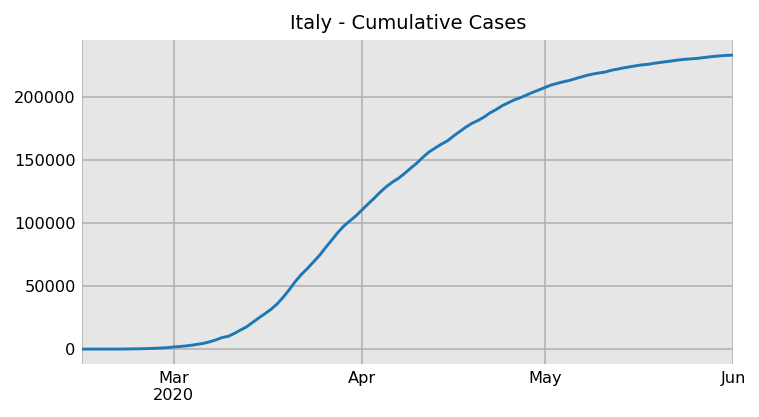

In [12]:
from prepare import PrepareData
data = PrepareData(download_new=False).run()
italyc = data['world_cases']['Italy']
italyc = italyc.loc["2020-02-15":"2020-06-01"]
italyc.plot(title="Italy - Cumulative Cases");

In [14]:
def logistic_guess_plot(s, L, x0, k):
    """
    Plots data with a logistic function estimate.

    Parameters
    ----------
    s : Series
    L, x0, k : float

    Returns
    -------
    None
    """
    x = np.arange(len(s))
    y = logistic_func(x, L, x0, k)
    s_guess = pd.Series(y, index=s.index)
    s.plot()
    s_guess.plot()

## Estimating logistic function parameters


In [16]:
from functions import smooth
last_date = '2020-04-01'
y = italyc.loc[:last_date]
y_smooth = smooth(y, n=15)
y_smooth.head()

2020-02-15     0.000000
2020-02-16     0.000000
2020-02-17     0.000000
2020-02-18     8.144961
2020-02-19    27.319120
dtype: float64

In [3]:
y_smooth.tail()


NameError: name 'y_smooth' is not defined

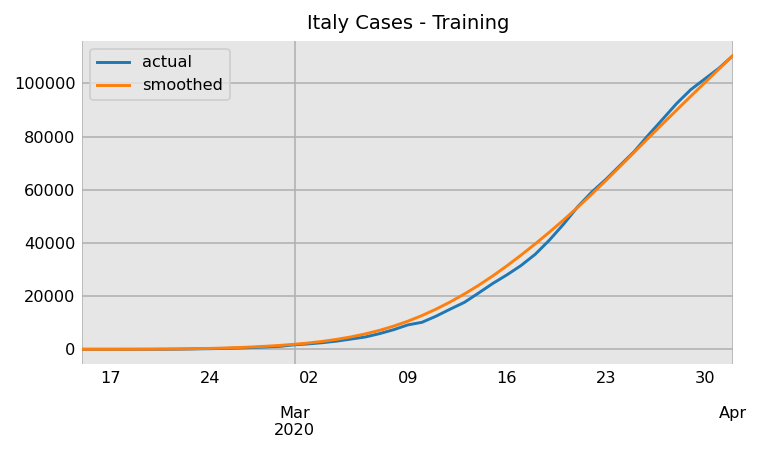

In [18]:
y.plot(label='actual', title="Italy Cases - Training");
y_smooth.plot(label='smoothed').legend();

### Parameter bounds

In [19]:
def plot_ks(s, ks, L, x0):
    """
    Visualizes various logistic curves to assist in parameter tuning.

    Parameters
    ----------
    s : Series
    ks : list of floats
    L, x0 : float

    Returns
    -------
    None
    """
    start = s.index[0]
    index = pd.date_range(start, periods=2 * x0)
    x = np.arange(len(index))
    s.plot(label="smoothed", lw=3, title=f"L={L:,} $x_0$={x0}", zorder=3)
    for k in ks:
        y = logistic_func(x, L, x0, k)
        y = pd.Series(y, index=index)
        y.plot(label=f"k={k}").legend()


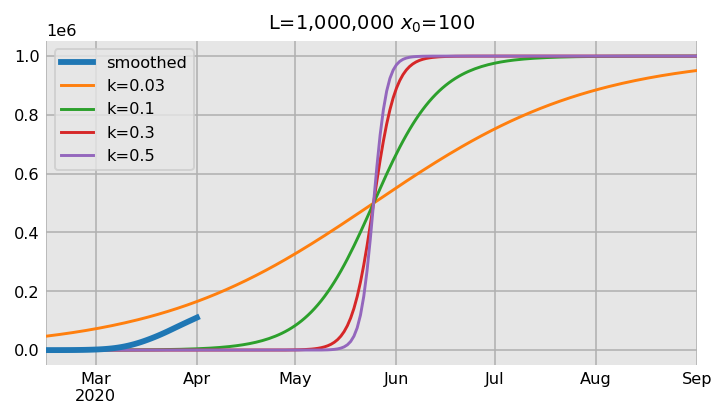

In [21]:
from functions import plot_ks
ks = [0.03, 0.1, 0.3, 0.5]
plot_ks(y_smooth, ks, 1_000_000, 100)

When using a shorter amount of time to the mid-point and an `L` of 200,000, the shape of the smoothed curve is closer to 0.1. 

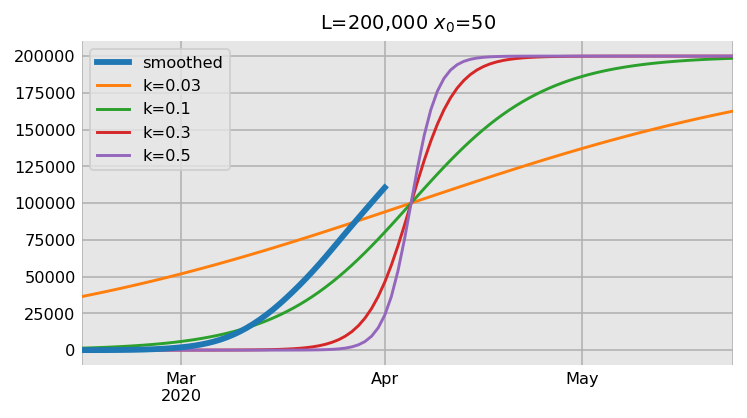

In [22]:
ks = [0.03, 0.1, 0.3, 0.5]
plot_ks(y_smooth, ks, 200_000, 50)

If we assume just a small future increase in total cases, the smoothed slope is closer to 0.3.



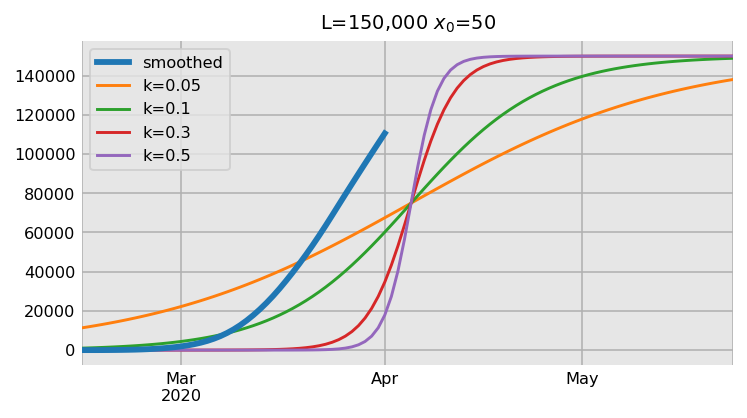

In [23]:
ks = [.05, 0.1, 0.3, 0.5]
plot_ks(y_smooth, ks, 150_000, 50)

We use `least_squares` just as before to get the fitted parameter values.

In [26]:
from functions import logistic_func, optimize_func
from scipy.optimize import least_squares
y = y_smooth
x = np.arange(len(y))
res = least_squares(optimize_func, p0, args=(x, y, logistic_func), bounds=bounds)
L, x0, k = res.x
print(f'L = {L:,.0f}\nx0 = {x0:.0f}\nk = {k:.3f}')

L = 136,194
x0 = 38
k = 0.164


Let's use our handy function `predict_all` to plot the next 50 days with this model.

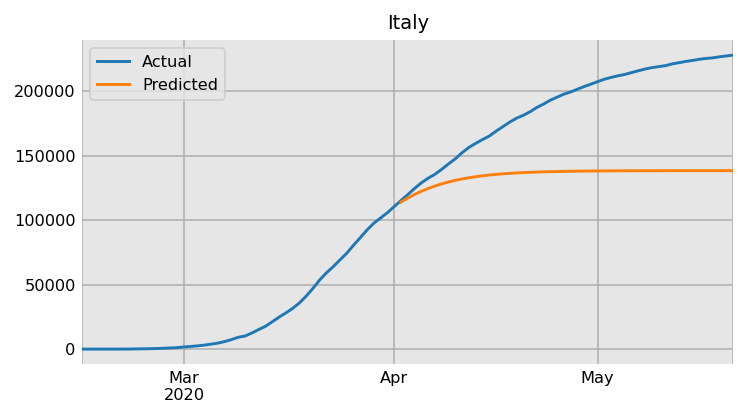

In [28]:
from functions import predict_all
predict_all(italyc, start_date=None, last_date="2020-04-01", n_pred=50, n_smooth=15, 
            model=logistic_func, bounds=bounds, p0=p0, title="Italy");

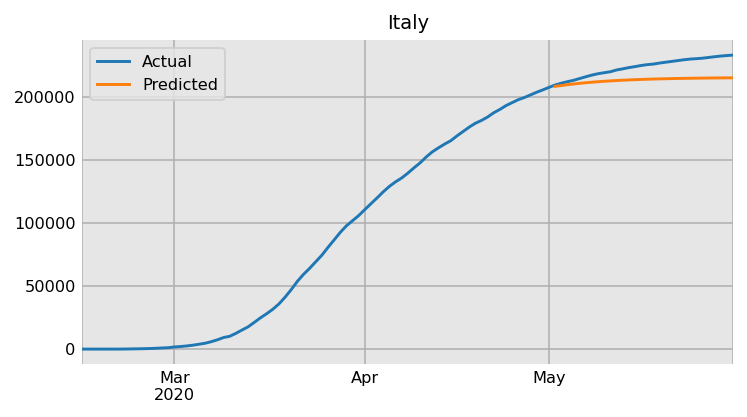

In [29]:
predict_all(italyc, start_date=None, last_date="2020-05-01", n_pred=30, n_smooth=15, 
            model=logistic_func, bounds=bounds, p0=p0, title="Italy");

## Generalized Logistic Function

$$f(x) = \frac{L}{(1 + e^{-k(x - x_0)})^{\frac{1}{v}}}$$





The parameters `L` and `k` maintain their previous meanings, representing the curve's maximum and the growth rate, respectively. A new parameter, `v`, is introduced to modify the curve's symmetry and effectuate a horizontal shift. It's important to note that `v` should always be positive. The impact of varying `v` is as follows:

- For `v < 1`:
  - The growth rate is accelerated before reaching the midpoint.
  - This results in the curve being shifted towards the right.

- For `v > 1`:
  - The growth rate is quicker post-midpoint.
  - Consequently, the curve is shifted towards the left.





In [5]:
def general_logistic(x, L, x0, k, v):
    return L / ((1 + np.exp(-k * (x - x0))) ** (1 / v))

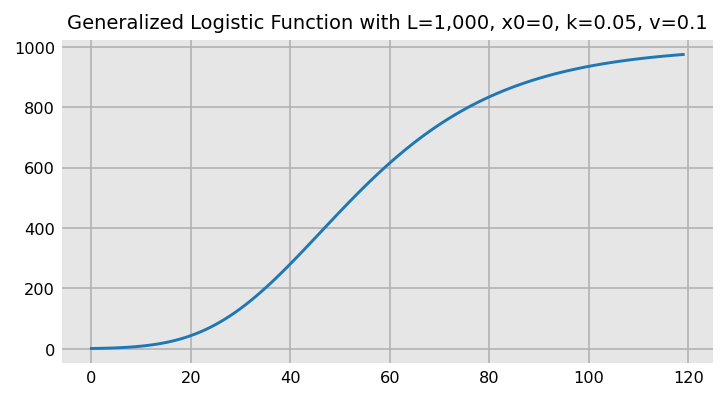

In [31]:
L, x0, k, v = 1_000, 0, 0.05, 0.1
x = np.arange(120)
y = general_logistic(x, L, x0, k, v)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title(f"Generalized Logistic Function with L={L:,}, x0={x0}, k={k}, v={v}");

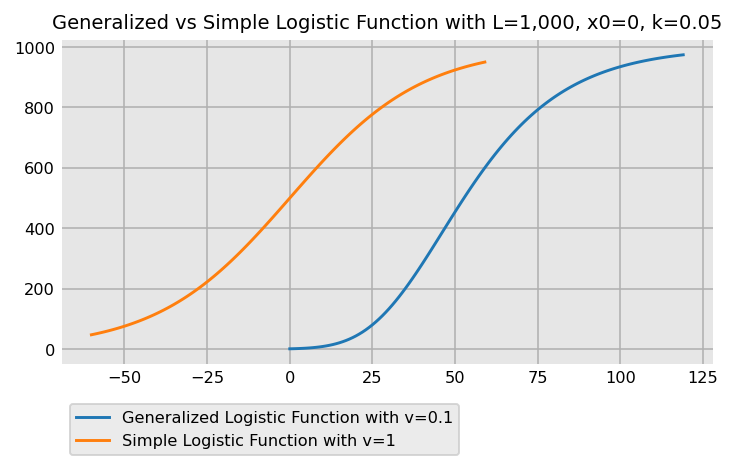

In [32]:
# same as above
L, x0, k, v = 1_000, 0, 0.05, 0.1
x = np.arange(120)
y = general_logistic(x, L, x0, k, v)

# v set to 1 - simple logistic function
L, x0, k, v = 1_000, 0, 0.05, 1
x1 = np.arange(-60, 60)
y1 = general_logistic(x1, L, x0, k, v)

fig, ax = plt.subplots()
ax.plot(x, y, label='Generalized Logistic Function with v=0.1')
ax.plot(x1, y1, label='Simple Logistic Function with v=1')
ax.legend(bbox_to_anchor=(0, -.1), loc='upper left')
ax.set_title(f"Generalized vs Simple Logistic Function with L={L:,}, x0={x0}, k={k}");

### Plotting Asymmetry


In [33]:
def plot_asymmetry(x, L, x0, k, v):
    y = general_logistic(x, L, x0, k, v)
    fig, ax = plt.subplots()
    ax.plot(x, y)
    low, mid, high = int(0.1 * L), int(0.5 * L), int(0.9 * L)
    ax.hlines([low, mid, high], x[0], x[-1], color='black', ls='--')
    
    days_to_10 = np.argmax(y > low)
    days_to_50 = np.argmax(y > mid)
    days_to_90 = np.argmax(y > high)
    days_10_to_50 = days_to_50 - days_to_10
    days_50_to_90 = days_to_90 - days_to_50
    ax.set_title(f"Generalized Logistic Function with L={L:,}, k={k}, v={v}")
    ax.text(0.05, 0.75, f'Days from {low} to {mid}: {days_10_to_50}', transform=ax.transAxes, size=8)
    ax.text(0.05, 0.68, f'Days from {mid} to {high}: {days_50_to_90}', transform=ax.transAxes, size=8)

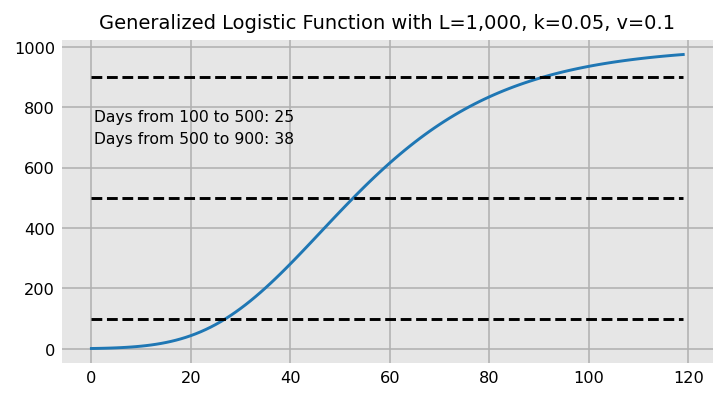

In [34]:
x = np.arange(120)
plot_asymmetry(x, L=1000, x0=0, k=0.05, v=0.1)

Setting `v` to 1 simplifies the logistic growth function by making it symmetric.


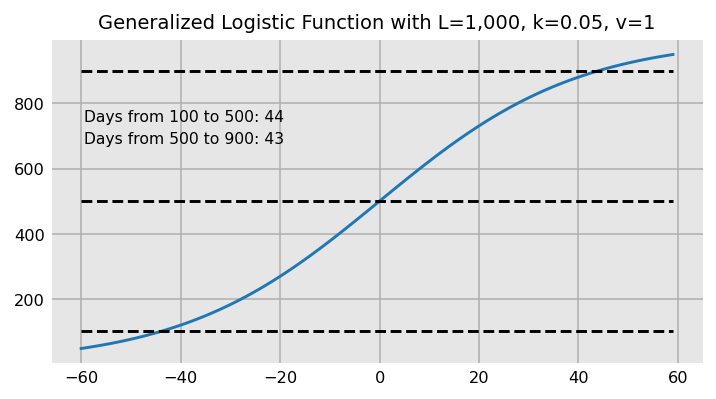

In [35]:
x = np.arange(-60, 60)
plot_asymmetry(x, L=1000, x0=0, k=0.05, v=1)

Setting the `v` value to 2 allows the curve to reach the right asymptote faster.  



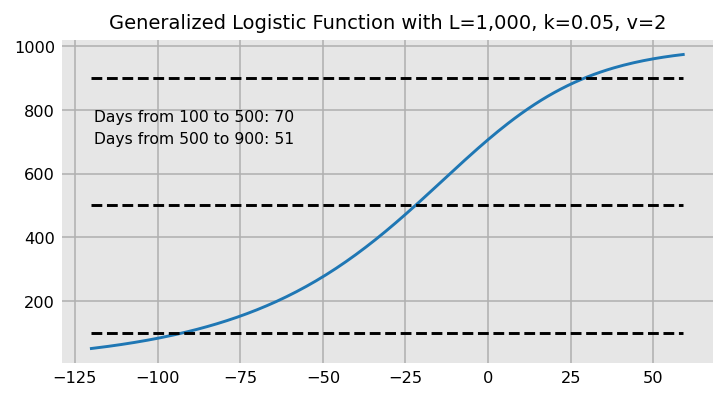

In [36]:
x = np.arange(-120, 60)
plot_asymmetry(x, L=1000, x0=0, k=0.05, v=2)

Increasing `k` as `v` increases helps decrease the time between the 10th and 90th percentile. 

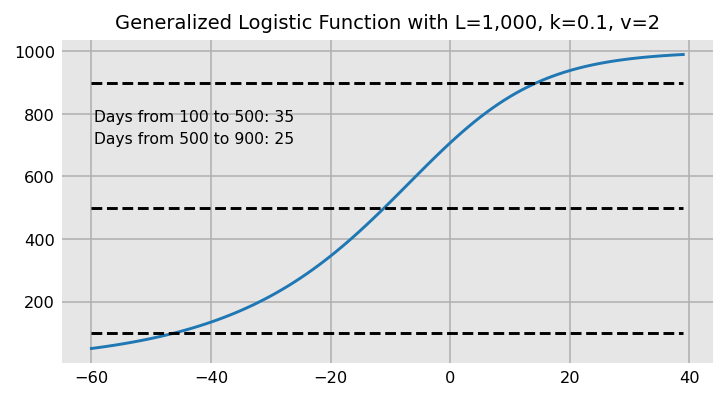

In [37]:
x = np.arange(-60, 40)
plot_asymmetry(x, L=1000, x0=0, k=0.1, v=2)

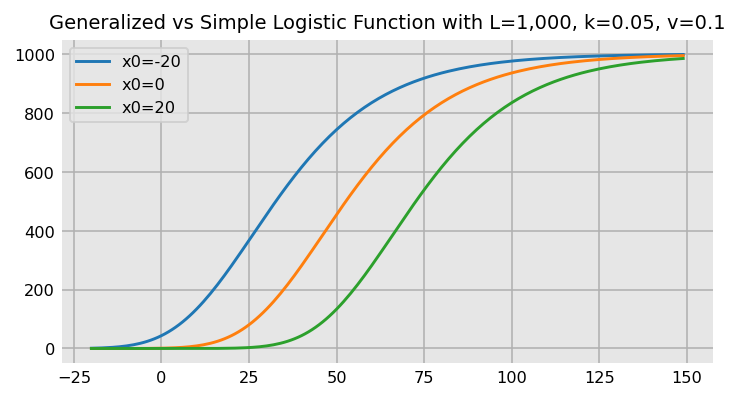

In [38]:
L, k, v = 1_000, 0.05, 0.1
x = np.arange(-20, 150)

fig, ax = plt.subplots()
for x0 in [-20, 0, 20]:
    y = general_logistic(x, L, x0, k, v)
    ax.plot(x, y, label=f'x0={x0}')
ax.legend()
ax.set_title(f"Generalized vs Simple Logistic Function with L={L:,}, k={k}, v={v}");

## Predictions with the generalized logistic function


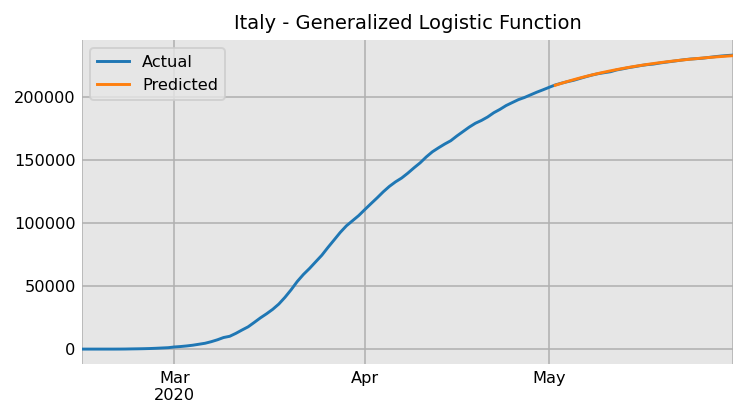

In [39]:
last_date = "2020-04-01"
L_min, L_max = italyc[last_date], 1_000_000
x0_min, x0_max = -50, 50
k_min, k_max = 0.01, 0.5
v_min, v_max = 0.01, 2
lower = L_min, x0_min, k_min, v_min
upper = L_max, x0_max, k_max, v_max
bounds = lower, upper
p0 = L_max, 0, 0.1, 0.1

params, y_pred = predict_all(italyc, start_date=None, last_date="2020-05-01", n_smooth=15,
                             n_pred=30, model=general_logistic, bounds=bounds, p0=p0, 
                             title="Italy - Generalized Logistic Function");

The predictive model now aligns with the actual values.

In [40]:
params

array([ 2.36841824e+05, -3.61763199e+01,  5.86413407e-02,  1.00000000e-02])

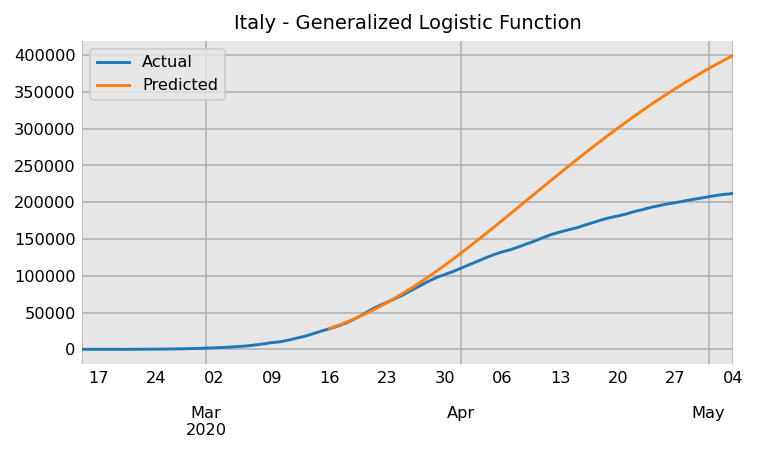

In [41]:
predict_all(italyc, start_date=None, last_date="2020-03-15", n_smooth=15, 
            n_pred=50, model=general_logistic, bounds=bounds, p0=p0, 
            title="Italy - Generalized Logistic Function");

## Modeling other countries

In [42]:
def model_country(data, name, start_date, last_date):
    s = data['world_cases'][name]    
    L_min, L_max = s.iloc[0], s.iloc[-1] * 1000
    x0_min, x0_max = -50, 50
    k_min, k_max = 0.01, 0.5
    v_min, v_max = 0.01, 2
    lower = L_min, x0_min, k_min, v_min
    upper = L_max, x0_max, k_max, v_max
    bounds = lower, upper
    p0 = L_min * 5, 0, 0.1, 0.1
    predict_all(s, start_date=start_date, last_date=last_date, n_smooth=15, 
                n_pred=50, model=general_logistic, bounds=bounds, p0=p0, 
                title=f"{name} - Generalized Logistic Function");

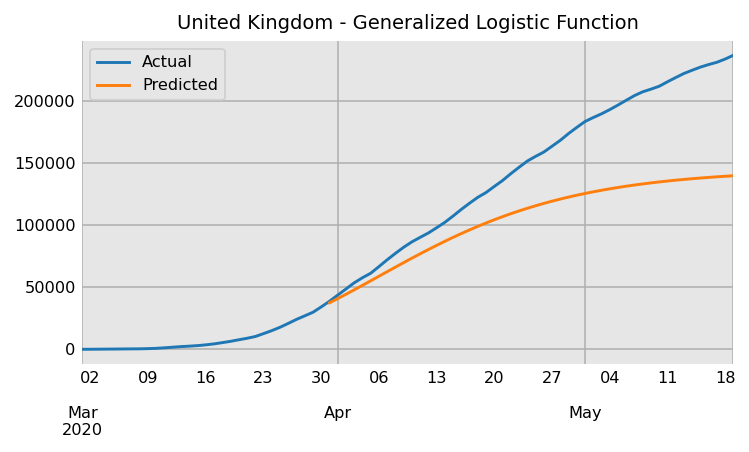

In [43]:
model_country(data, "United Kingdom", "2020-03-01", "2020-03-30")

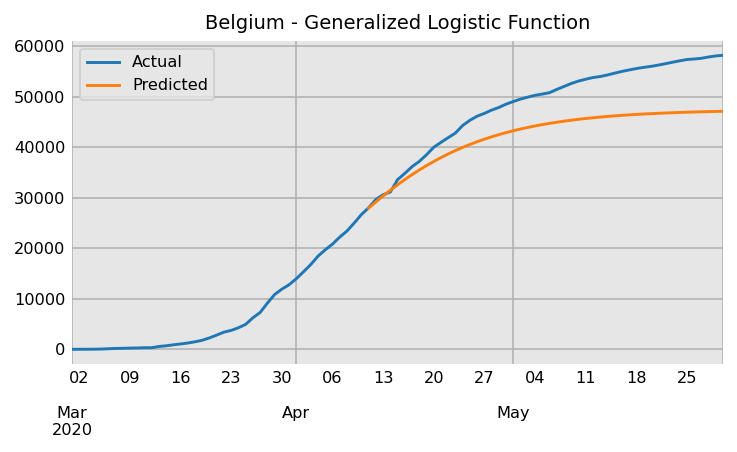

In [44]:
model_country(data, "Belgium", "2020-03-01", "2020-04-10")

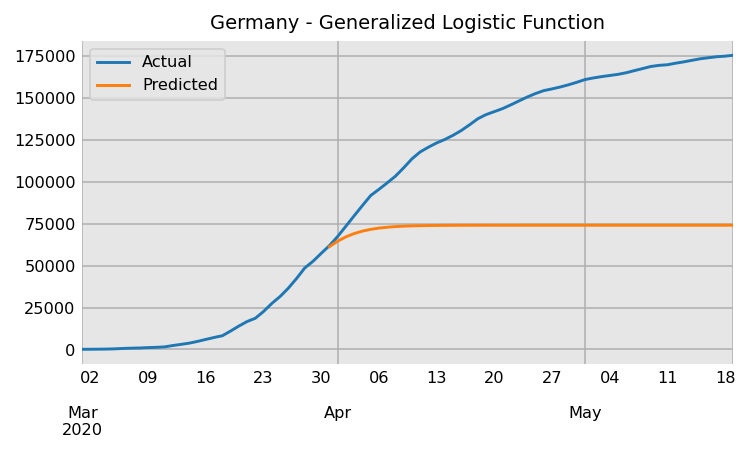

In [45]:
model_country(data, "Germany","2020-03-01", "2020-03-30")

In [4]:
model_country(data, "South Korea","2020-02-15", "2020-03-1")

NameError: name 'model_country' is not defined